# **Day 3 — Baselines & Metrics**

**Goals:**
- Load processed features from `data/day3_features.csv`
- Establish a baseline (majority class)
- Train logistic regression (scikit-learn)
- Evaluate: accuracy, confusion matrix, ROC-AUC, PR-AUC
- Tune decision threshold for F1

In [64]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
)

rng = np.random.default_rng(3)
print("Python:", sys.version.split()[0])

Python: 3.13.7


In [65]:
path = "data/day3_features.csv"
assert os.path.exists(path), f"Missing {path}. Run the EDA/feature notebook first."

dfp = pd.read_csv(path)

feature_cols = [c for c in dfp.columns if c.startswith("x_")]
X_train = dfp.loc[dfp["split"]=="train", feature_cols].to_numpy()
y_train = dfp.loc[dfp["split"]=="train", "y"].to_numpy().astype(int)

X_test  = dfp.loc[dfp["split"]=="test", feature_cols].to_numpy()
y_test  = dfp.loc[dfp["split"]=="test", "y"].to_numpy().astype(int)

X_train.shape, X_test.shape, len(feature_cols)

((6, 7), (2, 7), 7)

In [66]:
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)

yhat_base = baseline.predict(X_test)
acc_base = accuracy_score(y_test, yhat_base)
print("Baseline accuracy:", round(acc_base, 3))

Baseline accuracy: 1.0


In [67]:
logreg = LogisticRegression(max_iter=1000, solver="lbfgs")
logreg.fit(X_train, y_train)

y_proba_tr = logreg.predict_proba(X_train)[:, 1]
y_proba_te = logreg.predict_proba(X_test)[:, 1]

yhat_default = (y_proba_te >= 0.5).astype(int)
acc_lr = accuracy_score(y_test, yhat_default)
print("LogReg accuracy (0.5 threshold):", round(acc_lr, 3))

LogReg accuracy (0.5 threshold): 0.5


In [68]:
cm = confusion_matrix(y_test, yhat_default)
pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"])

,Pred 0,Pred 1
True 0,1,1
True 1,0,0


In [69]:
# Build features/target and a Logistic Regression pipeline
import os, sqlite3, numpy as np, pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# If df isn't defined yet, load it from the Day 3 hr.db
if "df" not in globals():
    db_path = "data/hr.db"
    assert os.path.exists(db_path), f"Database not found at {db_path}"
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql_query("SELECT * FROM employees", conn)

# Features/target
numeric_cols = ["age", "years_at_company", "monthly_income"]
categorical_cols = ["dept"]
X = df[numeric_cols + categorical_cols]
y = df["left_company"].to_numpy()

# Preprocess + model
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)
clf = Pipeline(steps=[
    ("pre", pre),
    ("logreg", LogisticRegression(max_iter=1000))
])

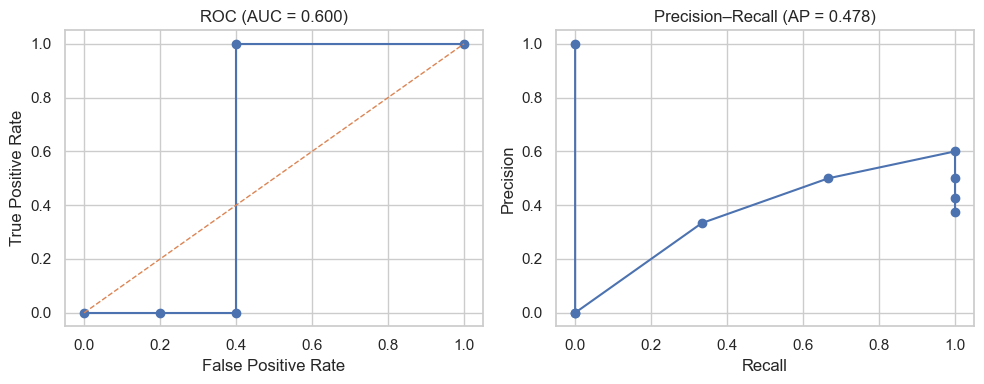

In [70]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Pick a safe n_splits given class counts
min_class = int(df["left_company"].value_counts().min())  # = 3 on your toy data
n_splits = max(2, min(3, min_class))  # 2 or 3 folds are safe here

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
proba_oof = cross_val_predict(clf, X, y, cv=cv, method="predict_proba")[:, 1]

# ROC & PR from OOF predictions
fpr, tpr, _ = roc_curve(y, proba_oof)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y, proba_oof)
ap = average_precision_score(y, proba_oof)

# Plots
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, marker="o", linewidth=1.5)
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.title(f"ROC (AUC = {roc_auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.subplot(1, 2, 2)
plt.plot(rec, prec, marker="o", linewidth=1.5)
plt.title(f"Precision–Recall (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()

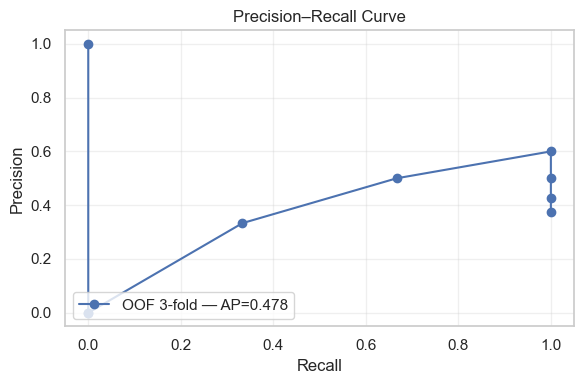

In [71]:
# Robust Precision–Recall: use holdout if valid, else OOF CV fallback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_curve, average_precision_score

def pr_curve_with_fallback(y_test, y_proba_te, X, y, clf):
    y_test = np.asarray(y_test)
    has_pos = (y_test.sum() > 0)
    has_neg = (y_test.sum() < len(y_test))

    if has_pos and has_neg:
        y_true, y_scores, label = y_test, y_proba_te, "Holdout"
    else:
        # Tiny data: keep folds small but stratified
        min_class = int(pd.Series(y).value_counts().min())
        n_splits = max(2, min(3, min_class))
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
        y_scores = cross_val_predict(clf, X, y, cv=cv, method="predict_proba")[:, 1]
        y_true, label = np.asarray(y), f"OOF {n_splits}-fold"

    prec, rec, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(6, 4))
    plt.plot(rec, prec, marker="o", linewidth=1.5, label=f"{label} — AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call it (uses your existing variables X, y, clf, y_test, y_proba_te):
pr_curve_with_fallback(y_test, y_proba_te, X, y, clf)

In [72]:
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict

def best_f1_threshold(y_true, y_score, grid=np.linspace(0.05, 0.95, 19)):
    f1s = [f1_score(y_true, (y_score >= th).astype(int)) for th in grid]
    best_idx = int(np.argmax(f1s))
    return float(grid[best_idx]), float(f1s[best_idx])

def evaluate_with_fallback(y_tr, proba_tr, y_te, proba_te, X_all, y_all, clf):
    # Choose threshold on TRAIN (you could also choose via CV below)
    th_tr, f1_tr = best_f1_threshold(y_tr, proba_tr)
    print(f"Best threshold on train (F1): {th_tr:.3f} | F1(train)={f1_tr:.3f}")

    has_pos = (np.sum(y_te) > 0)
    has_neg = (np.sum(y_te) < len(y_te))

    if has_pos and has_neg:
        yhat = (proba_te >= th_tr).astype(int)
        print("\nClassification report @ best threshold (holdout):\n")
        print(classification_report(y_te, yhat, labels=[0,1], digits=3, zero_division=0))
        print("Confusion matrix (holdout):\n", confusion_matrix(y_te, yhat, labels=[0,1]))
    else:
        print("\n[Note] Holdout has a single class; falling back to OOF CV for a fairer estimate.")
        # OOF predictions on ALL data
        counts = np.bincount(y_all)
        min_class = int(counts.min())
        n_splits = max(2, min(3, min_class))  # keep folds small but valid
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
        proba_oof = cross_val_predict(clf, X_all, y_all, cv=cv, method="predict_proba")[:, 1]
        th_cv, f1_cv = best_f1_threshold(y_all, proba_oof)
        yhat_oof = (proba_oof >= th_cv).astype(int)
        print(f"Best threshold from OOF: {th_cv:.3f} | F1(OOF)={f1_cv:.3f}")
        print("\nClassification report @ best threshold (OOF):\n")
        print(classification_report(y_all, yhat_oof, labels=[0,1], digits=3, zero_division=0))
        print("Confusion matrix (OOF):\n", confusion_matrix(y_all, yhat_oof, labels=[0,1]))

# Run it (uses your existing variables X, y, clf, y_train, y_proba_tr, y_test, y_proba_te):
evaluate_with_fallback(y_train, y_proba_tr, y_test, y_proba_te, X, y, clf)

Best threshold on train (F1): 0.400 | F1(train)=1.000

[Note] Holdout has a single class; falling back to OOF CV for a fairer estimate.
Best threshold from OOF: 0.200 | F1(OOF)=0.750

Classification report @ best threshold (OOF):

              precision    recall  f1-score   support

           0      1.000     0.600     0.750         5
           1      0.600     1.000     0.750         3

    accuracy                          0.750         8
   macro avg      0.800     0.800     0.750         8
weighted avg      0.850     0.750     0.750         8

Confusion matrix (OOF):
 [[3 2]
 [0 3]]


**Summary**
- Baseline vs Logistic Regression performance compared
- Curves (ROC / PR) visualize ranking quality
- Tuned decision threshold for F1 (train) and evaluated on test

**Next**
- Try feature ablations or interaction terms
- Compare other models (e.g., tree-based) using the same feature table